In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import pytz
from pytz import timezone
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tz = timezone('US/Central') # This data uses GMT-6 rather than standard CST/CDT
def toUTC(d):
    return tz.normalize(tz.localize(d)).astimezone(pytz.utc)

In [3]:
def string2datetime(stringDTSeries):
    try:
        return [(dt.datetime.strptime(DT,'%Y/%m/%d %I:%M:%S %p')) for DT in stringDTSeries]
    except(ValueError):
        try:
            return [(dt.datetime.strptime(DT,'%Y/%m/%d %H:%M:%S')) for DT in stringDTSeries]
        except(ValueError):
            try:
                return [(dt.datetime.strptime(DT,'%m/%d/%Y %I:%M:%S %p')) for DT in stringDTSeries]
            except(ValueError):
                try:
                    return [(dt.datetime.strptime(DT,'%m/%d/%Y %H:%M:%S')) for DT in stringDTSeries]
                except(ValueError):
                    return [(dt.datetime.strptime(DT,'%m/%d/%y %H:%M:%S')) for DT in stringDTSeries]

In [4]:
# path = '/Volumes/RT&O/C Brace/GPS Analysis/' #mac
path = 'X:/C Brace/GPS Analysis/' #win


## Add LandUse coordinates and weartime to UIC preprocessed GPS files

In [35]:
x = Gpsdata['UTC DATE']+' '+Gpsdata['UTC TIME'] #full date/time
GpsDates = string2datetime(x) #convert to datetime object
GpsDates=pd.Series(GpsDates)

In [36]:
GpsDates[:10]

0   2015-02-10 17:42:37
1   2015-02-10 17:42:47
2   2015-02-10 17:42:57
3   2015-02-10 17:43:07
4   2015-02-10 17:43:17
5   2015-02-10 17:43:27
6   2015-02-10 17:43:37
7   2015-02-10 17:43:47
8   2015-02-10 17:43:57
9   2015-02-10 17:44:07
dtype: datetime64[ns]

In [38]:
#Baseline: UIC Gps preprocessed Data
#GPSdata: raw Gps data with wear time fraction
#GpsDates: datetime object from Gpsdata to match with UIC data
def add_latlonwear(Baseline,Gpsdata,GpsDates):
    loc_lat = []
    loc_lon = []
    wear_frac = []

    for i in range(len(Baseline)):
        start = Baseline.BeginTime[i]
        end = Baseline.EndTime[i]
        d = Baseline.Date[i]
        
        if type(d) != str:
            d = d.strftime('%Y/%m/%d') 
        if type(start) != str:
            start = str(start)
        if type(end) != str:
            end = str(end)
        try:
            startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y/%m/%d %H:%M:%S'))
            enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y/%m/%d %H:%M:%S'))
        except(ValueError):
            try:
                startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%y %H:%M:%S'))
                enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%y %H:%M:%S'))
            except(ValueError):
                try:
                    startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%Y %H:%M:%S'))
                    enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%Y %H:%M:%S'))
                except(ValueError):
                    startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y-%m-%d %H:%M:%S'))
                    enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y-%m-%d %H:%M:%S'))



        ind = (GpsDates >= startdate) & (GpsDates <= enddate)
        meanLat = np.mean(Gpsdata['LATITUDE'][ind])
        meanLon = np.mean(Gpsdata['LONGITUDE'][ind])
        if np.isnan(meanLat) or np.isnan(meanLon):
            print('null found %s'%any(ind))
            print(startdate,enddate)
        loc_lat.append(meanLat)
        loc_lon.append(meanLon)

        wear_ind = (Gpsdata['Wear/Non-Wear']=='Wear') & ind
        wear_frac.append(sum(wear_ind)/sum(ind))

    Baseline['Mean Lat'] = loc_lat
    Baseline['Mean Lon'] = loc_lon
    Baseline['Wear Frac'] = wear_frac


# Loop through files and add Lat, Lon and Wear Time to UIC files

In [ ]:
fwt = os.listdir(path+'GPSWT/')
fconv = os.listdir(path+'UIC_GPSData/w_LatLonWear/')

for f in list(set(fwt)-set(fconv)):
    try:
        #load files
        print(f)
        Gpsdata = pd.read_csv(path+'GPSWT/'+f)
        #include long sign
        lonsgn = np.cos((Gpsdata['E/W']=='W')*np.pi)
        Gpsdata['LONGITUDE'] = Gpsdata['LONGITUDE']*lonsgn
        Subjid = f[:5]
        trial = f[6] #cbrace,SCO or baseline
        switcher = {'C':'CBR','S':'SCO','B':'Baseline'}
        UICdata = pd.read_excel(path+'UIC_GPSData/'+Subjid+'_Final_Summary_File.xlsx',sheetname=switcher[trial])
        
        #convert date formats from raw gps
        x = Gpsdata['UTC DATE']+' '+Gpsdata['UTC TIME'] #full date/time
        GpsDates = string2datetime(x) #convert to datetime object
        GpsDates=pd.Series(GpsDates)
                       
#         #match dates and add lat lon and weartime to UIC processed data
        add_latlonwear(UICdata,Gpsdata,GpsDates)
        
#         #save file
        UICdata.to_csv(path+'UIC_GPSData/w_LatLonWear/'+f)
    except(FileNotFoundError):
        print('File not found')

# Load Files and aggregate per brace

In [5]:
Data = pd.DataFrame()
for f in os.listdir(path+'UIC_GPSData/w_LatLonWear/'):
#     print(f)
    if os.path.isfile(os.path.join(path+'UIC_GPSData/w_LatLonWear/',f)):
        d = pd.read_csv(os.path.join(path+'UIC_GPSData/w_LatLonWear/',f))
        del d['Unnamed: 0']
        d['SubjID'] = str(f[:5])
        d['Brace'] = str.capitalize(f[6:9])
        Data = pd.concat([Data,d]) #concatenate data from each subj
    else:
        #skip directories
        continue

In [6]:
cols=list((Data.columns).values)
cols.remove('SubjID')
cols.remove('Brace')
Data = Data[['SubjID','Brace']+cols]
Data['LandUse'] = Data.LandUse.astype(str)
# Data['BeginTime']= Data[['BeginTime']].applymap(lambda x: dt.datetime.strptime(x,'%H:%M:%S').time())
# Data['EndTime']= Data[['EndTime']].applymap(lambda x: dt.datetime.strptime(x,'%H:%M:%S').time())
Data.head()

,SubjID,Brace,BeginTime,Date,Duration,EndTime,LandUse,MaximumSpeed,Mean Lat,Mean Lon,MeanSpeed,MinimumSpeed,Mode,Numberpoints,Sequence,TotalGap,Wear Frac
0,CBR08,Cbr,11:42:37,2015-02-10,27.35,12:09:58,Trip,NaN,41.870200,-87.711023,46.9405,NaN,Car,165,1,0.559999,1.0
1,CBR08,Cbr,12:10:08,2015-02-10,7.16667,12:17:18,COM_URBMIX,NaN,41.830436,-87.803025,2.28438,NaN,NaN,44,2,0.146667,1.0
2,CBR08,Cbr,12:17:28,2015-02-10,19,12:36:28,Trip,NaN,41.839046,-87.767186,20.0673,NaN,Car,115,3,0.383333,1.0
3,CBR08,Cbr,12:36:38,2015-02-10,9,12:45:38,COM_URBMIX,NaN,41.851519,-87.747862,1.56251,NaN,NaN,55,4,0.183333,1.0
4,CBR08,Cbr,12:45:48,2015-02-10,69.3667,13:55:10,Trip,NaN,41.872845,-87.685020,26.8295,NaN,Car,379,5,7.603332,1.0


## Anonymize home location

In [7]:
Data.loc[Data.LandUse=='Home','Mean Lat'] = 41.8938732
Data.loc[Data.LandUse=='Home','Mean Lon'] = -87.6209879

In [9]:
Data[Data.LandUse=='Home']['Mean Lon'].unique()

array([-87.6209879])

In [12]:
#save anonymzed data
Data.to_csv(os.path.join(path+'UIC_GPSData/w_LatLonWear/','Anonymzed/AnonymzedData.csv'))

## Data cleaning

In [60]:
landuse=Data[['LandUse']]
landuse=landuse.applymap(lambda x: str.capitalize(x))
Data['LandUse'] = landuse

In [61]:
c = Data.LandUse.value_counts(normalize=True)
c[:10]

Trip                   0.449575
Home                   0.211468
Com_urbmix             0.123557
Com_regional           0.046683
Res_sf_detached        0.040213
Res_mf                 0.024610
Non-parcel road row    0.016618
Com_bigbox             0.012812
Com_office             0.011417
Inst_medical           0.008372
Name: LandUse, dtype: float64

In [62]:
sum(c[:3]) #top 3 locs account for most data

0.78459977166053529

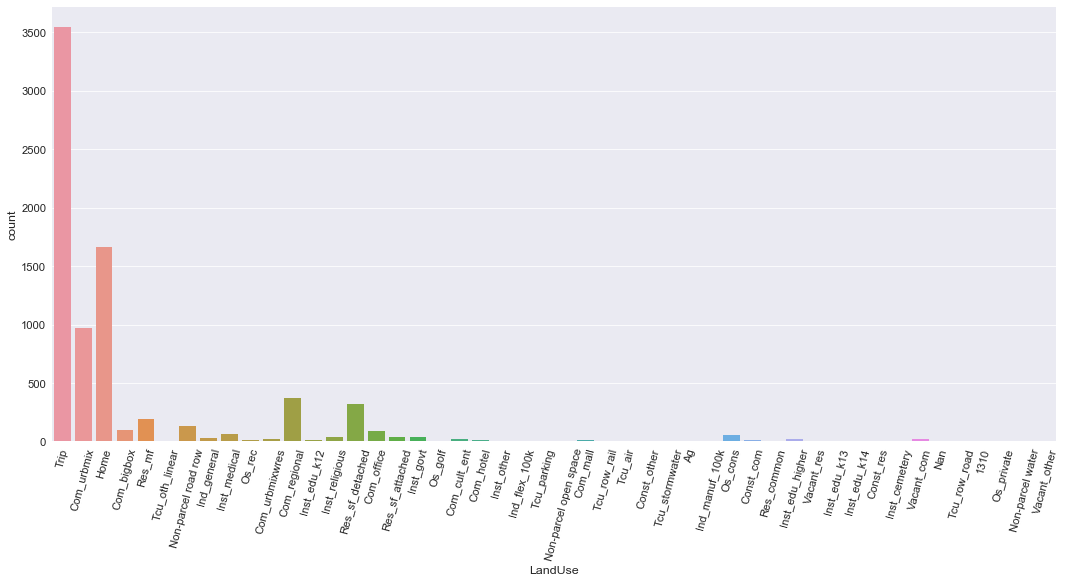

In [63]:
sns.set_context('paper',font_scale=1.4)
plt.figure(figsize=(18,8))
ax = sns.countplot(Data.LandUse)
ax = plt.xticks(rotation=75)

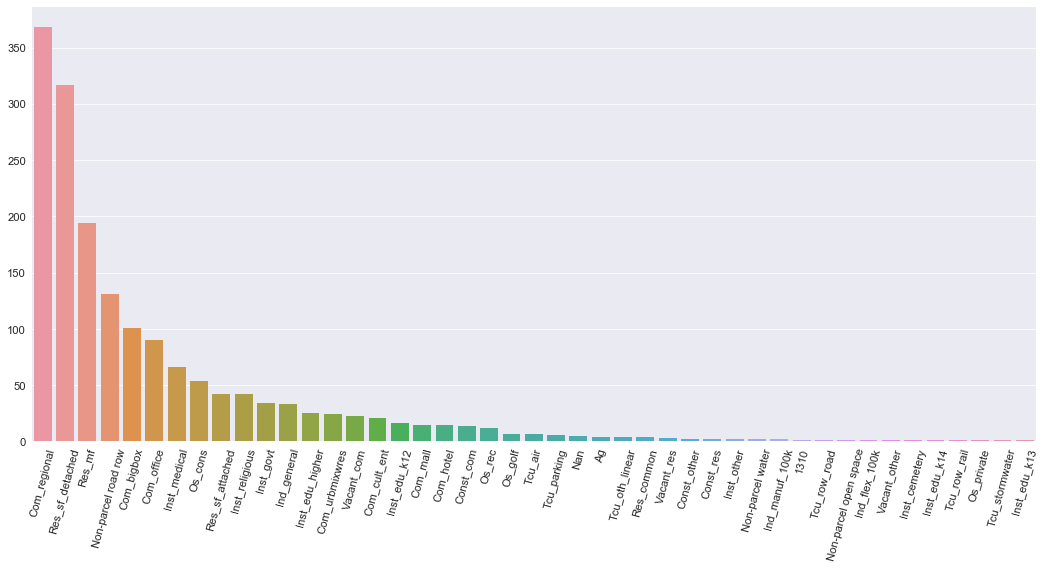

In [64]:
c = Data.LandUse.value_counts(normalize=False)
sns.set_context('paper',font_scale=1.4)
plt.figure(figsize=(18,8))
sns.barplot(x=c[3:].index,y=c[3:].values)
ax = plt.xticks(rotation=75)

## Time spent at home

In [10]:
Data['Brace'].unique()

array(['Cbr', 'Sco', 'Bas'], dtype=object)

In [11]:
durCbr = Data[(Data['LandUse']=='Home')&(Data['Brace']=='Cbr')]['Duration']
durCbr = durCbr.values.astype(float)
durCbr=durCbr[~np.isnan(durCbr)]
durSCO = Data[(Data['LandUse']=='Home')&(Data['Brace']=='Sco')]['Duration']
durSCO = durSCO.values.astype(float)
durSCO=durSCO[~np.isnan(durSCO)]
durBase = Data[(Data['LandUse']=='Home')&(Data['Brace']=='Bas')]['Duration']
durBase = np.asarray([float(x) for x in durBase.values if type(x) is float])
durBase=durBase[~np.isnan(durBase)]

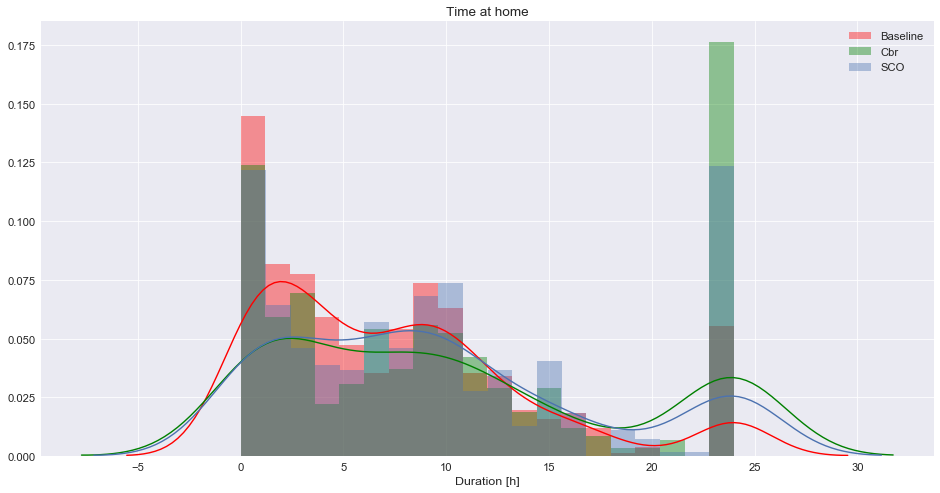

In [12]:
nb = 20
sns.set_context(font_scale=3)
plt.figure(figsize=(16,8))
sns.distplot(durBase/60,color='r',bins=nb)
sns.distplot(durCbr/60,color='g',bins=nb)
sns.distplot(durSCO/60,bins=nb)
plt.xlabel('Duration [h]')
plt.legend(['Baseline','Cbr','SCO'])
plt.title('Time at home')

## Time spent in trips

In [13]:
durCbr = Data[(Data['LandUse']=='Trip')&(Data['Brace']=='Cbr')]['Duration']
durCbr = durCbr.values.astype(float)
durSCO = Data[(Data['LandUse']=='Trip')&(Data['Brace']=='Sco')]['Duration']
durSCO = durSCO.values.astype(float)
durBase = Data[(Data['LandUse']=='Trip')&(Data['Brace']=='Bas')]['Duration']
durBase = durBase.values.astype(float)

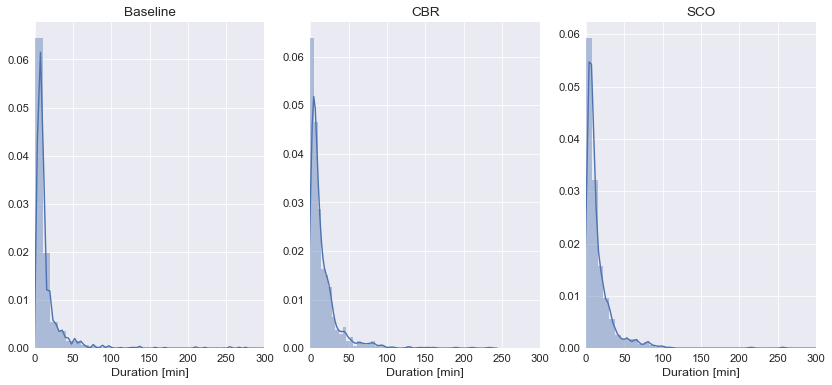

In [14]:
fig = plt.figure(figsize=(14,6))
fig.add_subplot(131)
ax = sns.distplot(durBase)
plt.xlim([0,300])
plt.title('Baseline')
plt.xlabel('Duration [min]')
fig.add_subplot(132)
ax = sns.distplot(durCbr)
plt.xlim([0,300])
plt.title('CBR')
plt.xlabel('Duration [min]')
fig.add_subplot(133)
ax = sns.distplot(durSCO)
plt.xlim([0,300])
plt.title('SCO')
plt.xlabel('Duration [min]')

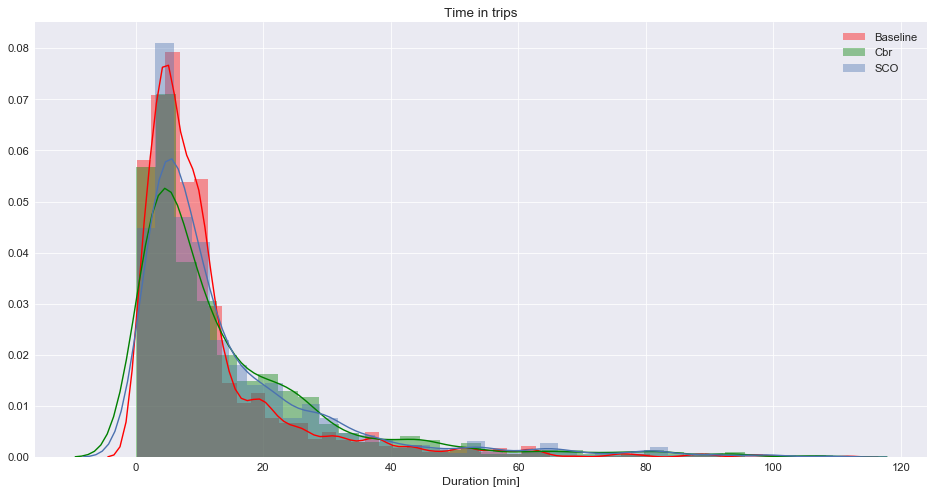

In [467]:
sns.set_context(font_scale=3)
plt.figure(figsize=(16,8))
sns.distplot(durBase[durBase<120],color='r')
sns.distplot(durCbr[durCbr<120],color='g')
sns.distplot(durSCO[durSCO<120])
plt.legend(['Baseline','Cbr','SCO'])
plt.xlabel('Duration [min]')
plt.title('Time in trips')

## Time spent at locations other than home and trip

In [18]:
durCbr = Data[~((Data['LandUse']=='Trip')|(Data['LandUse']=='Home'))&(Data['Brace']=='Cbr')]['Duration']
durCbr = durCbr.values.astype(float)
durSCO = Data[~((Data['LandUse']=='Trip')|(Data['LandUse']=='Home'))&(Data['Brace']=='Sco')]['Duration']
durSCO = durSCO.values.astype(float)
durBase = Data[~((Data['LandUse']=='Trip')|(Data['LandUse']=='Home'))&(Data['Brace']=='Bas')]['Duration']
durBase = durBase.values.astype(float)

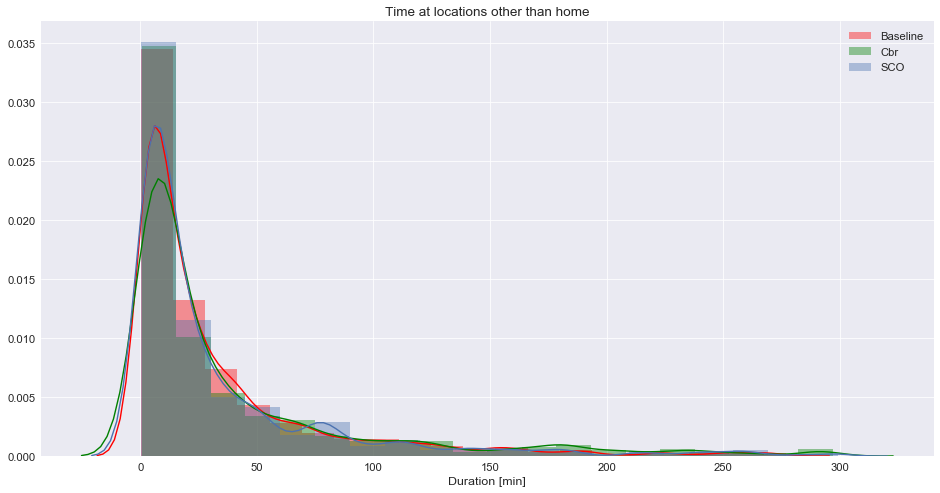

In [19]:
nb = 20
sns.set_context(font_scale=3)
plt.figure(figsize=(16,8))
sns.distplot(durBase[durBase<300],color='r',bins=nb)
sns.distplot(durCbr[durCbr<300],color='g',bins=nb)
sns.distplot(durSCO[durSCO<300],bins=nb)
plt.xlabel('Duration [min]')
plt.legend(['Baseline','Cbr','SCO'])
plt.title('Time at locations other than home')

## Wear Fractions for each brace
* Proportion of trips w/wo brace
* Correlation of wearfrac and Trip duration

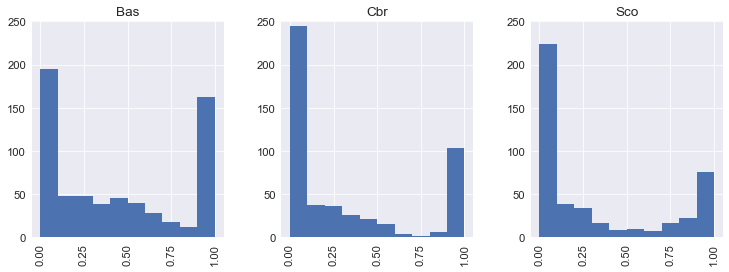

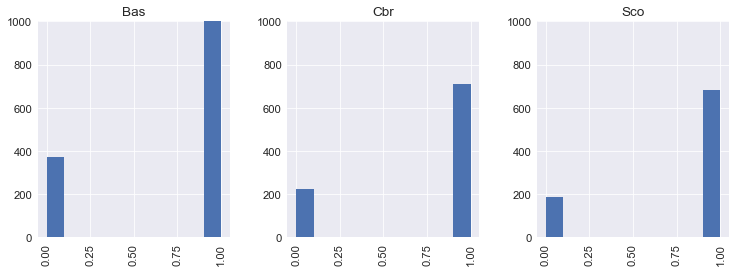

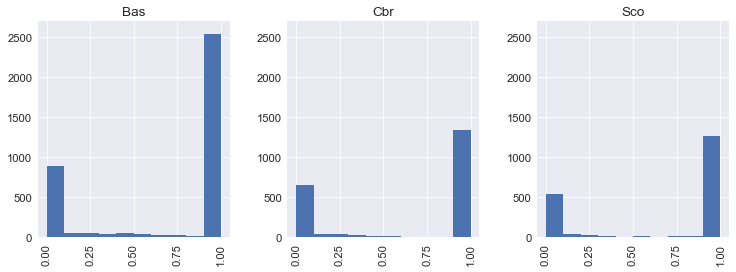

In [399]:
#wearfrac during trips,home and other use
ax = Data[(Data['LandUse']=='Home')].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))
for a in ax:
    a.set_ylim([0,250])
ax = Data[(Data['LandUse']=='Trip')].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))
for a in ax:
    a.set_ylim([0,1000])
ax = Data[~((Data['LandUse']=='Home')&(Data['LandUse']=='Trip'))].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))
for a in ax:
    a.set_ylim([0,2700])


# Do people travel further from home with the cbrace?
* Median distance from home with each brace

In [532]:
#Include sign to Longitude
Data['Mean Lon']= Data['Mean Lon']*-1

In [549]:
#plot test datapoint
import gmplot
gmap = gmplot.GoogleMapPlotter(37.428, -122.145, 16)
gmap.scatter([home[0],home[0]],[home[1],home[1]],'k', marker=True)
gmap.draw("mymap.html")

In [541]:
??gmplot.GoogleMapPlotter

In [503]:
#store distance of each location visited from home
from geopy.distance import vincenty
dist = pd.Series()
for s in Data.SubjID.unique():
    #first update the lat,lon of home for each subj with its mean
    homelat = Data[(Data['SubjID']==s)&(Data['LandUse']=='Home')]['Mean Lat'].mean()
    homelon = Data[(Data['SubjID']==s)&(Data['LandUse']=='Home')]['Mean Lon'].mean()
    
    #distance of locations (other than trips from home)
    home = np.array((homelat,homlon))
    dist = vincenty()

# distinct locations visited per brace